In [1]:
import sys,os
import pandas as pd
import numpy as np
import warnings

import tensorflow as tf
from sklearn.utils import shuffle
from joblib import load, dump
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns

from aggmap import AggMap
import aggmap

warnings.filterwarnings("ignore")

def imshow(x_arr,  ax,  color_list = ['#ff0c00','#25ff00', '#1300ff','#d000ff','#e2ff00', 
              '#00fff6', '#ff8800', '#fccde5','#178b66', '#8a0075'], x_max = 255, vmin = -1, vmax = 1,):
    
    
    assert x_arr.ndim == 3, 'input must be 3d array!'
    w, h, c = x_arr.shape
    assert len(color_list) >= c, 'length of the color list should equal or larger than channel numbers'
    
    x = x_arr.copy()
    x[x == 0] = 'nan'

    xxx = x_arr.sum(axis=-1)
    xxx[xxx != 0] = 'nan'
        
    
    cmaps = [sns.light_palette(color, n_colors =  100, reverse=False) for color in color_list]

    for i in range(c):
        data = x[:,:,i]/x_max
        sns.heatmap(data, cmap = cmaps[i],  vmin = vmin, vmax = vmax,  
                    yticklabels=False, xticklabels=False, cbar=False, ax=ax, ) # linewidths=0.005, linecolor = '0.9'

    sns.heatmap(xxx, vmin=0, vmax=1, cmap = 'Greys', yticklabels=False, xticklabels=False, cbar=False, ax=ax)
    #-100000
    
    ax.axhline(y=0, color='grey',lw=2, ls =  '--')
    ax.axhline(y=data.shape[0], color='grey',lw=2, ls =  '--')
    
    ax.autoscale()
    ax.axvline(x=data.shape[1], color='grey',lw=2, ls =  '--')  
    ax.axvline(x=0, color='grey',lw=2, ls =  '--')


def imshow_wrap(x):
    fig, ax = plt.subplots(figsize=(4,4))
    imshow(x.astype(float), ax=ax, x_max = 255, vmin = -0.001, vmax=1)
    

def tracked_orignal_change(orignal_image, new_mp):
    
    #mp = mp_ORSAggS4
    #orignal_image = trainX_OR1[0]
    df = new_mp._S.df.copy()
    SI = df.groupby('Subtypes').apply(lambda x:x.index.to_list())
    M, N, C = orignal_image.shape
    v = orignal_image.reshape(M*N*C, )
    arr_res = []
    for i, j in SI.items():
        j = [int(k.replace('p-',''))-1 for k in j]
        arr_1d = np.zeros(M*N, )
        arr_1d[j] = v[j]
        arr = arr_1d.reshape(M, N)  
        arr_res.append(arr)
    arr_tracked = np.stack(arr_res, axis=-1)
    return arr_tracked



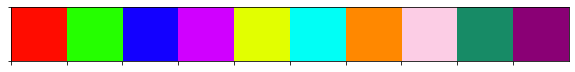

In [2]:
color_list = ['#ff0c00','#25ff00', '#1300ff','#d000ff','#e2ff00', 
              '#00fff6', '#ff8800', '#fccde5','#178b66', '#8a0075'] #colors for different channels
sns.palplot(color_list)

In [3]:
results_save_folder = './imgs'


In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data() #(x_train, y_train), (x_test, y_test)
mnist_labels_dict = {0: 'T-shirt/top',1: 'Trouser',2: 'Pullover',
                     3: 'Dress',4: 'Coat', 5: 'Sandal', 
                     6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}
seed = 88

In [8]:
## 1) orignal(c=1): OR1
_, w, h = x_train.shape
trainX_OR1 = x_train.reshape(x_train.shape[0], w, h, 1)
testX_OR1 = x_test.reshape(x_test.shape[0], w, h, 1)

label_idxs = pd.Series(y_train).to_frame(name = 'labels').groupby('labels').apply(lambda x:x.index.to_list())

orignal_cols = ['p-%s' % str((i+1)).zfill(len(str(w*h))) for i in range(w*h)]

## 1) rd shuffle
x_train_df = pd.DataFrame(x_train.reshape(x_train.shape[0], w*h), columns = orignal_cols)
x_test_df = pd.DataFrame(x_test.reshape(x_test.shape[0], w*h), columns = orignal_cols)
shuffled_cols = shuffle(orignal_cols, random_state= 7)
x_train_df = x_train_df[shuffled_cols]
x_test_df = x_test_df[shuffled_cols]

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

X = [trainX_OR1]

sizes = [60000, 30000, 12000,  6000, 600, 60]

for test_size in sizes:
    if test_size == 60000:
        dfx = x_train_df
    else:
        sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=0)
        tridx, tsidx = list(sss.split(x_train_df, y_train))[0]
        dfx = x_train_df.iloc[tsidx]
    
    mp = AggMap(dfx, metric = 'correlation')
    mp = mp.fit(verbose = 0, cluster_channels=1, var_thr = 0)
    x = mp.batch_transform(x_train_df.iloc[:2000].values, scale = False, n_jobs = 10)

    X.append(x)

2020-08-13 12:33:06,141 - INFO - [bidd-aggmap] - Calculating distance ...
2020-08-13 12:33:06,184 - INFO - [bidd-aggmap] - the number of process is 16


100%|##########| 784/784 [00:02<00:00, 323.77it/s]


2020-08-13 12:34:04,864 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2020-08-13 12:34:06,252 - INFO - [bidd-aggmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)


  0%|          | 0/2000 [00:00<?, ?it/s]

2020-08-13 12:34:07,050 - INFO - [bidd-aggmap] - Finished


100%|##########| 2000/2000 [00:09<00:00, 212.43it/s]


2020-08-13 12:34:16,831 - INFO - [bidd-aggmap] - Calculating distance ...
2020-08-13 12:34:16,873 - INFO - [bidd-aggmap] - the number of process is 16


100%|##########| 784/784 [00:01<00:00, 465.74it/s]


2020-08-13 12:34:48,121 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2020-08-13 12:34:49,502 - INFO - [bidd-aggmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)


  0%|          | 0/2000 [00:00<?, ?it/s]

2020-08-13 12:34:50,461 - INFO - [bidd-aggmap] - Finished


100%|##########| 2000/2000 [00:09<00:00, 221.47it/s]


2020-08-13 12:34:59,738 - INFO - [bidd-aggmap] - Calculating distance ...
2020-08-13 12:34:59,772 - INFO - [bidd-aggmap] - the number of process is 16


100%|##########| 784/784 [00:01<00:00, 562.20it/s]


2020-08-13 12:35:14,616 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2020-08-13 12:35:16,000 - INFO - [bidd-aggmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)


  0%|          | 0/2000 [00:00<?, ?it/s]

2020-08-13 12:35:16,783 - INFO - [bidd-aggmap] - Finished


100%|##########| 2000/2000 [00:08<00:00, 230.33it/s]


2020-08-13 12:35:25,755 - INFO - [bidd-aggmap] - Calculating distance ...
2020-08-13 12:35:25,788 - INFO - [bidd-aggmap] - the number of process is 16


100%|##########| 784/784 [00:01<00:00, 729.72it/s]


2020-08-13 12:35:39,745 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2020-08-13 12:35:41,124 - INFO - [bidd-aggmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)


  0%|          | 0/2000 [00:00<?, ?it/s]

2020-08-13 12:35:41,970 - INFO - [bidd-aggmap] - Finished


100%|##########| 2000/2000 [00:08<00:00, 239.30it/s]


2020-08-13 12:35:50,610 - INFO - [bidd-aggmap] - Calculating distance ...
2020-08-13 12:35:50,644 - INFO - [bidd-aggmap] - the number of process is 16


100%|##########| 784/784 [00:00<00:00, 850.78it/s]


2020-08-13 12:36:03,110 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2020-08-13 12:36:04,532 - INFO - [bidd-aggmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)


  0%|          | 0/2000 [00:00<?, ?it/s]

2020-08-13 12:36:05,186 - INFO - [bidd-aggmap] - Finished


100%|##########| 2000/2000 [00:08<00:00, 246.94it/s]


2020-08-13 12:36:13,583 - INFO - [bidd-aggmap] - Calculating distance ...
2020-08-13 12:36:13,622 - INFO - [bidd-aggmap] - the number of process is 16


100%|##########| 784/784 [00:01<00:00, 755.09it/s]


2020-08-13 12:36:25,958 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2020-08-13 12:36:27,451 - INFO - [bidd-aggmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)


  0%|          | 0/2000 [00:00<?, ?it/s]

2020-08-13 12:36:28,327 - INFO - [bidd-aggmap] - Finished


100%|##########| 2000/2000 [00:07<00:00, 284.86it/s]


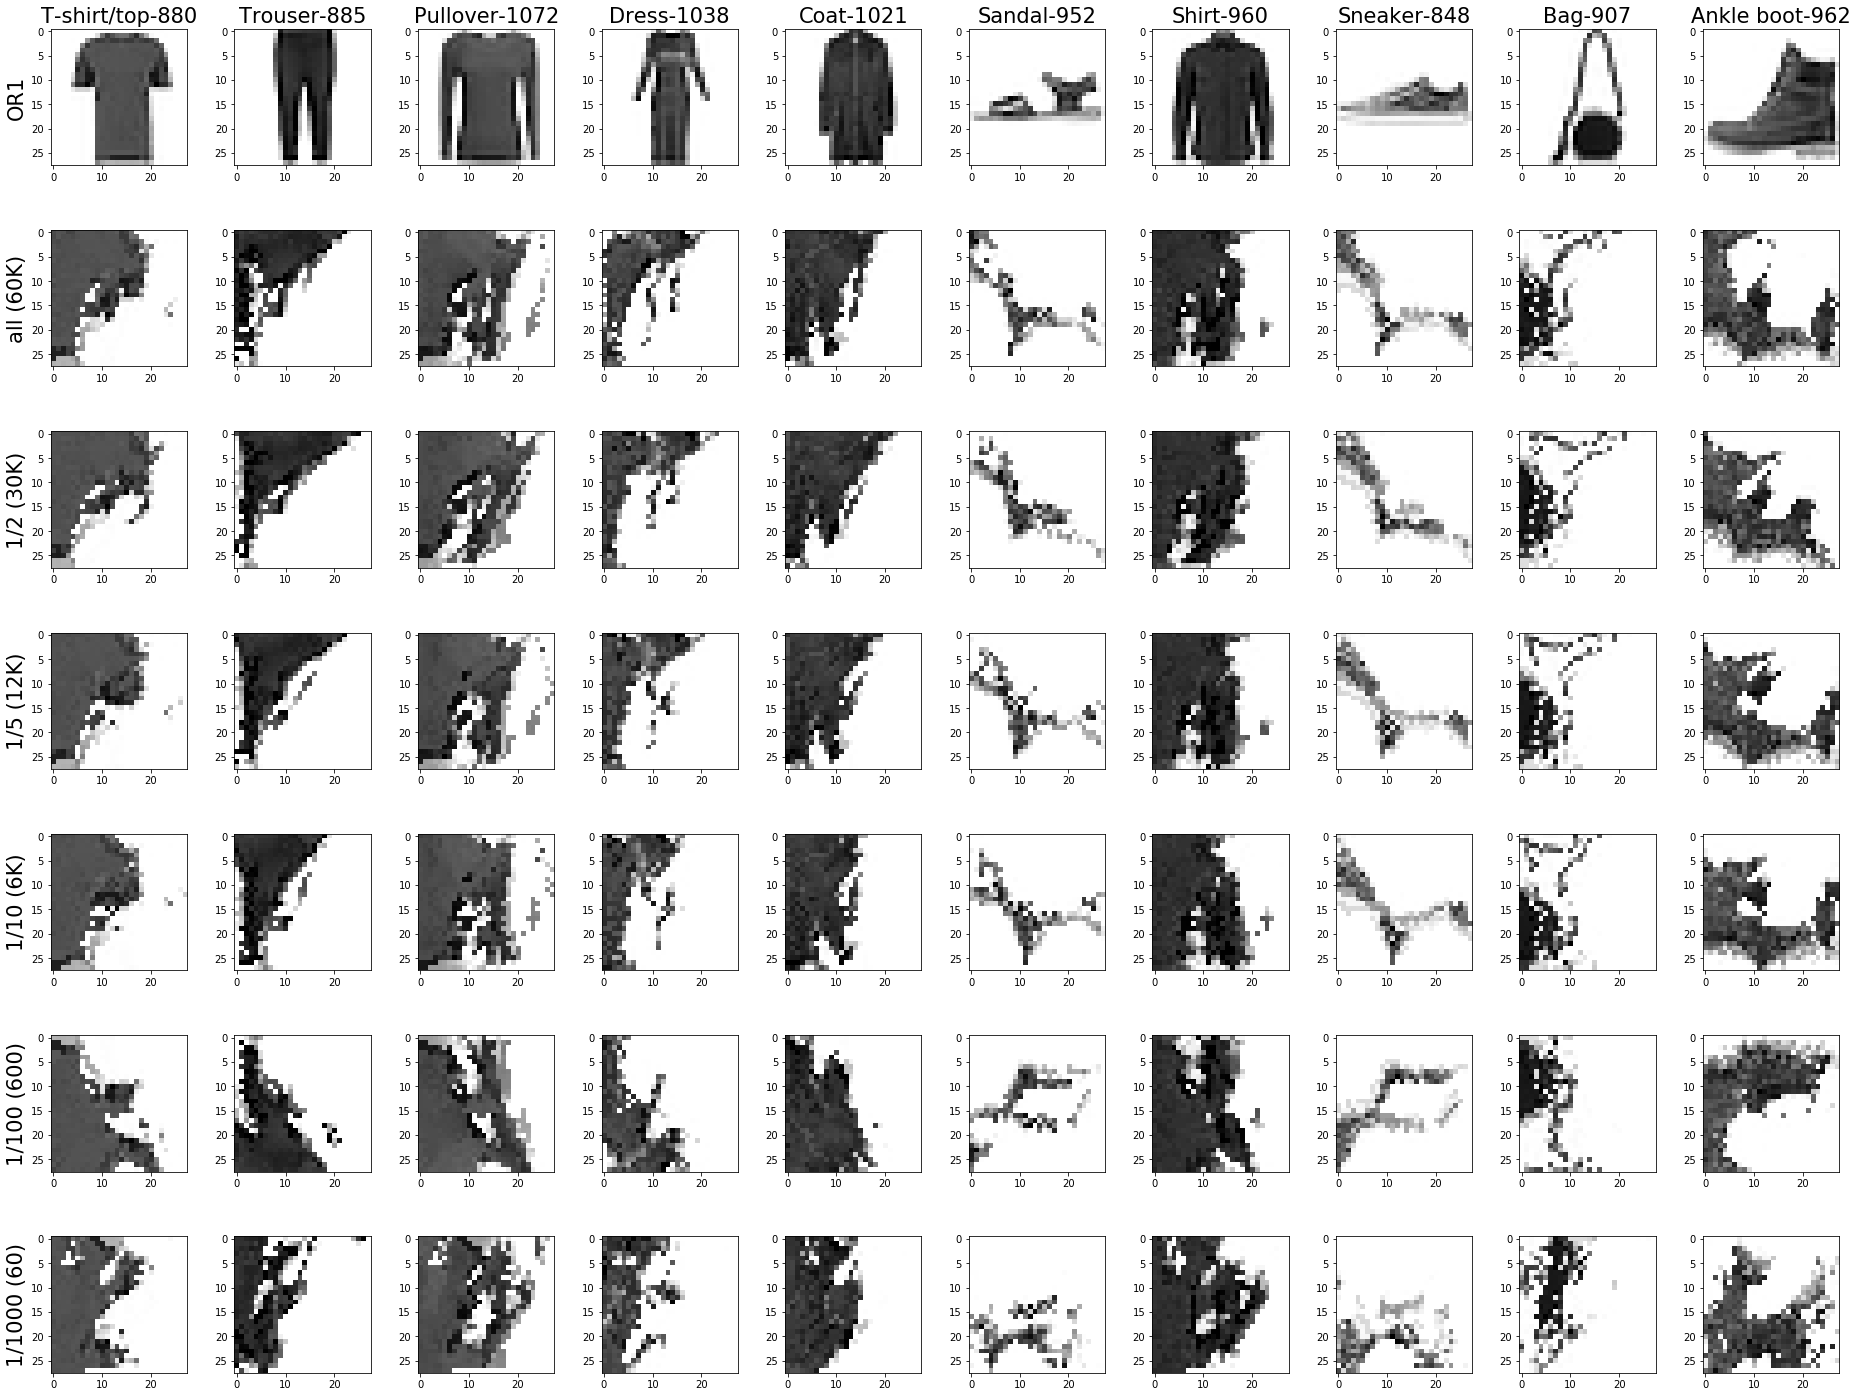

In [10]:
rows = ['OR1', 'all (60K)', '1/2 (30K)', '1/5 (12K)', '1/10 (6K)', '1/100 (600)', '1/1000 (60)']

cols = list(mnist_labels_dict.values())

image_idx = [pd.Series(label_idxs[i][:100]).sample(1, random_state = seed).to_list()[0] for i in range(len(label_idxs))]
cols = [i + '-%s' % j for i,j in zip(cols, image_idx)]

fig, axes = plt.subplots(nrows=7, ncols=10, figsize=(26,20), sharex = False, sharey = False)

fontsize = 21

## plot transformed images
for axc, x_ in zip(axes, X):
    for ax, idx in zip(axc, image_idx):
        x = x_[idx].astype(float)
        #imshow(x, ax=ax)
        ax.imshow(x.reshape((x.shape[0],x.shape[1])), cmap=plt.cm.Greys)
        
for ax, col in zip(axes[0], cols):
    ax.set_title(col, fontdict = {'fontsize': fontsize})
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, fontsize = fontsize)    


fig.tight_layout()
fig.savefig(os.path.join(results_save_folder, 'featuremaps_11_samples_effect_blank.png'), bbox_inches='tight', dpi=300) 